# PyTorch 로 순환신경망 만들기

In [1]:
# 두개의 LSTM 층을 쌓아 IMDB 리뷰 데이터 분류

In [2]:
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
  torch.backends.cudnn.deterministic=True


# 데이터 준비

In [3]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
train_input.shape, val_input.shape, test_input.shape

((20000,), (5000,), (25000,))

In [5]:
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [6]:
train_seq.shape, val_seq.shape

((20000, 100), (5000, 100))

In [7]:
# PyTorch Tensor
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [8]:
# DataSet 과 DataLoader 준비
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# 모델

In [27]:
import torch.nn as nn

class IMDBLstm(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(500, 16)

    # LSTM(입력크기, 출력크기)
    # PyTorch 순환층은 기본적으로 입력차원 (시퀀스 길이, 배치크기, 임베딩 크기) 으로 가정합니다.
    # 하지만, 위 예에서 Embedding 층을 통과한 출력은 배치크기가 맨 앞에 놓여 있다. (배치크기, 시퀀스 길이, 임베딩 크기)
    # 따라서 '배치 차원' 이 맨 앞이라는 것을 알리기 위해 batch_first=True 로 지정.
    self.lstm = nn.LSTM(16, 8, batch_first=True, num_layers=2, dropout=0.2)
                                      # ↑ keras 와 달리 PyTorch 는 여러개의 순환신경망을 쌓을 필요 없이 num_layers= 를 지정해주면 된다
    self.dense = nn.Linear(8, 1)
    self.sigmoid = nn.Sigmoid()  # sigmoid 함수가 포함된 손실함수가 있긴 하다.
            # 단, 이 예에제서는 다른 예를 보이기 위해 일부러 sigmoid 함수를 마지막에 추가할거다.

  def forward(self, x):
    x = self.embedding(x)
    # PyTorch 의 LSTM 클래스는 마지막 층에서 세개의 값 리턴
    #   '마지막 층의 타임스텝의 은닉상태'
    #   '모든 층의 최종 은닉 상태'
    #   '모든 층의 최종 셀 상태'

    # 각 '타임스텝의 은닉상태'는
    #   batch_first=True 로 지정된 경우  (배치크기, 시퀀스 길이, 뉴런개수)
    #   batch_first=False 로 지정된 경우  (시퀀스 길이, 배치크기, 뉴런개수)

    # '최종 은닉상태' 는 (층 개수, 배치크기, 뉴런 개수)
    # 현재 샘플의 길이가 100, 2개의 순환층, 64개의 배치
    #  첫번째 출력의 크기는 (64, 100, 8),  두번째 출력의 크기는 (2, 64, 8)

    # 이 예제에선 각 타임스텝의 은닉상태는 불필요.  순환신경망이 리턴는 두번째 값만 사용

    _, (hidden, _) = self.lstm(x)

    # 최종 출력인 두번째 층의 마지막 값을 선택
    outputs = self.dense(hidden[-1])
    return self.sigmoid(outputs)


model = IMDBLstm()


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
model.to(device)

IMDBLstm(
  (embedding): Embedding(500, 16)
  (lstm): LSTM(16, 8, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [30]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# 훈련

In [31]:
train_hist = []
val_hist = []

# early stopping
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):

  # 훈련
  model.train()
  train_loss = 0

  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)


    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs.squeeze(), targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  # 검증
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), targets)
      val_loss += loss.item()

  train_loss = train_loss/len(train_loader)
  val_loss = val_loss/len(val_loader)
  train_hist.append(train_loss)
  val_hist.append(val_loss)

  print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  # 최적의 모델 save, early stopping
  if best_loss == -1 or val_loss < best_loss:
    # 모델 성능이 개선이 되었다면
    best_loss = val_loss
    early_stopping_counter = 0
    torch.save(model.state_dict(), 'best_2lstm_model.pt')

  else:
    # 모델 성능이 개선이 되지 않았다면
    early_stopping_counter += 1
    if early_stopping_counter >= patience:
      print(f'Early stopping at epoch {epoch+1}')
      break  # epoch 종료.






Epoch: 1/100, Train Loss: 0.6851, Val Loss: 0.6648
Epoch: 2/100, Train Loss: 0.6287, Val Loss: 0.5942
Epoch: 3/100, Train Loss: 0.5632, Val Loss: 0.5429
Epoch: 4/100, Train Loss: 0.5225, Val Loss: 0.5174
Epoch: 5/100, Train Loss: 0.5058, Val Loss: 0.5045
Epoch: 6/100, Train Loss: 0.4775, Val Loss: 0.4910
Epoch: 7/100, Train Loss: 0.4832, Val Loss: 0.4874
Epoch: 8/100, Train Loss: 0.4723, Val Loss: 0.4714
Epoch: 9/100, Train Loss: 0.4610, Val Loss: 0.4672
Epoch: 10/100, Train Loss: 0.4446, Val Loss: 0.4628
Epoch: 11/100, Train Loss: 0.4370, Val Loss: 0.4604
Epoch: 12/100, Train Loss: 0.4328, Val Loss: 0.4582
Epoch: 13/100, Train Loss: 0.4274, Val Loss: 0.4557
Epoch: 14/100, Train Loss: 0.4192, Val Loss: 0.4482
Epoch: 15/100, Train Loss: 0.4274, Val Loss: 0.4486
Epoch: 16/100, Train Loss: 0.4151, Val Loss: 0.4470
Epoch: 17/100, Train Loss: 0.4331, Val Loss: 0.4565
Epoch: 18/100, Train Loss: 0.4193, Val Loss: 0.4573
Early stopping at epoch 18


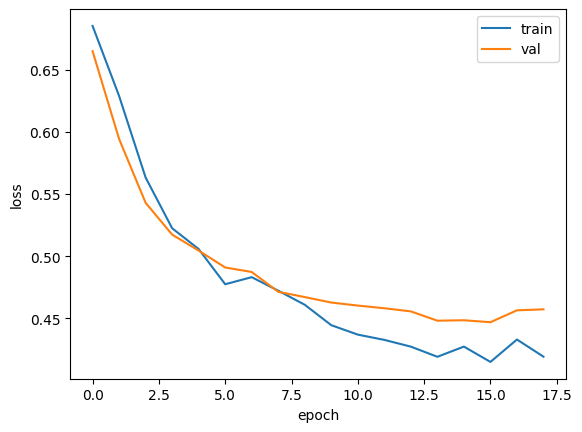

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [33]:
!ls

best_2lstm_model.pt  sample_data


In [36]:
model.load_state_dict(torch.load('best_2lstm_model.pt'))

<All keys matched successfully>

# 평가

In [37]:
model.eval()

corrects = 0

with torch.no_grad():
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    predicts = outputs > 0.5
    corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f'검증 정확도: {accuracy:.4f}')


검증 정확도: 0.7882


In [39]:
# 테스트 셋 점수
test_seq = pad_sequences(test_input, maxlen=100)
test_seq = torch.tensor(test_seq)
test_target = torch.tensor(test_target, dtype=torch.float32)

test_dataset = TensorDataset(test_seq, test_target)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model.eval()

corrects = 0

with torch.no_grad():
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    predicts = outputs > 0.5
    corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(test_dataset)
print(f'테스트 정확도: {accuracy:.4f}')

/tmp/ipython-input-2108871520.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_target = torch.tensor(test_target, dtype=torch.float32)


테스트 정확도: 0.7979
